# Final Answer

To explain what Bayesian Optimization is, let's use a simple toy example.

### The problem.

Our goal is to find an approximate minimum to an 'expensive' function. This function accepts a real valued vector $\mathbf{x}\in\mathbb{R}^D$, returns a scalar and takes a damn long time in between. Also, no gradient calculation is available. So let's imagine a simple one dimensional case:

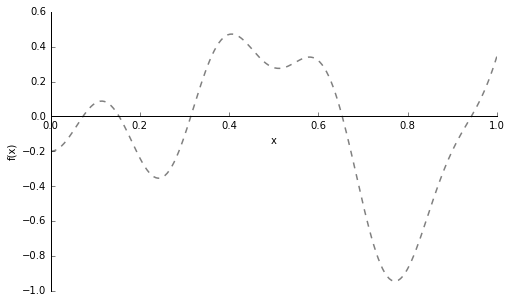

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
%matplotlib inline

from scipy.optimize import minimize

# plt.style.use('dark_background')

x = np.linspace(0,1,200)

def f(x):
    return -(np.sin(x*10)*x + np.cos(x*25)*.2)
y = f(x)

bounds = [(0,1)]
f_opt = minimize(f,.5,bounds=bounds)
x_true = f_opt.x[0]
f_x_true = f(x_true)
xlims = (0,1)
ylims = (-1,.6)

def true_func(ax):

    ax.plot(x,y,linestyle='--',linewidth=1.5,color='grey')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('data',0))
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data',0))
    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')
    
    return ax

fig, ax = plt.subplots(figsize=(8,5))
ax = true_func(ax)
ax.set_ylim(ylims)
ax.set_xlim(xlims)
fig.savefig('hiddenfunction',dpi=250)
pass

The dotted lines imply we can't see this function - we may only choose to evaluate it at certain points.

To capture the idea that this function is 'expensive', let's say we have a fixed budget of evaluation - we may only evaluate it, say, 10 times.

With that, how would you find the best possible minimum? 

Here's one stupid idea:

### Random Sampling

randomly pick 10 points to evaluate and take the minimum. Picture it like this:

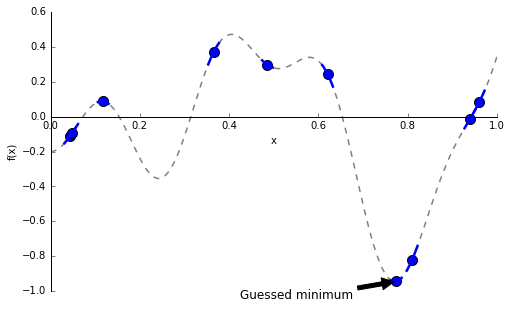

In [2]:
def eval_points(ax, xi):
    xi_extend = xi + np.linspace(-.012,.012,10)
    yi_extend = f(xi_extend)
    ax.plot(xi_extend,yi_extend,linestyle='-',linewidth=2.5,color='blue')
        
x_samp = np.random.uniform(size=10)
def plot_rand_approach(ax):
    ax = true_func(ax)
    for xi in x_samp:
        eval_points(ax, xi)
    y_samp = f(x_samp)
    ax.scatter(x_samp,y_samp,s=100)
    ax.set_ylim(ylims)
    ax.set_xlim(xlims)
        
    return ax
        
np.random.seed(3)
fig, ax = plt.subplots(figsize=(8,5))
ax = plot_rand_approach(ax)

ys = f(x_samp)
x_min = x_samp[np.argmin(ys)]
y_min = f(x_min)
ax.annotate('Guessed minimum',xy=(x_min,y_min),xytext=(x_min-.35,y_min-.1),
            fontsize=12,
           arrowprops=dict(facecolor='black', shrink=0.05))

fig.savefig('random_sample.png',dpi=250)

This will work, but can we do better? Can we choose the next point wisely depending on what we've seen thus far?

Yep, we certainly can.

### Bayesian Optimization (using Gaussian Processes)

This is the idea: Sample some input-outputs (less than 10) and use them to *guess* the true function with something called a  'Gaussian Process'. Then use that guessed function to determine where to evaluate next. Evaluate that point and perform the inference again. Repeat this until you've exhausted your budget of evaluations (or some other stopping criteria). If the GP is any good at guessing the function, we should do a pretty good job at finding our minimum point.

If you don't know what a Guassian process is, I can tell you the imporant pieces for our purposes. It's simply a way of inferring a function (like the one we see above) from samples of it's inputs and outputs. In other words, with just inputs and outputs, it provides a cheap 'guess' as to what the full function looks like. Not only that, it also provides a *distribution* over the outputs. So when you guess the function output at some given x, the guessian process will also tell us the probability of finding it within some range. If you want to know more about it, you can read about it here [link to my other answer].

To get a feel for the GP, let's sample four points from our expensive function, hand these over to our guassian process and have it infer the rest of the function. That might look like this:

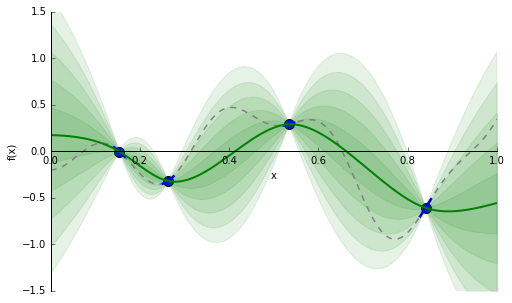

In [3]:
import sklearn.gaussian_process.kernels as ker

kernel = ker.RBF(1) + ker.WhiteKernel()
# kernel = ker.RBF(1)
# kernel = 10*ker.RBF(1) + .5*ker.RBF(1) + ker.RBF(10) + ker.WhiteKernel(.01)
kernel = ker.Matern(.04) +  ker.WhiteKernel(.01)
# kernel = 1**2*ker.Matern(length_scale=1,nu=1.5)
# kernel = ker.ExpSineSquared()
# kernel = ker.KernelRidge()
GP = GaussianProcessRegressor(kernel=kernel)

x_samp = np.array([0.15416284,0.26331502,0.53373939,0.84])
# x_samp = np.linspace(0,1,10)

def guassian_on_four(ax,x_samp):
    for xi in x_samp:
        eval_points(ax, xi)
    y_samp = f(x_samp)
    ax.scatter(x_samp,y_samp,s=100)
    GP.fit(x_samp.reshape(-1,1),y_samp)
    y_pred, sigma = GP.predict(x.reshape(-1,1), return_std=True)
    ax.plot(x, y_pred, linestyle='-', color='green',linewidth=2)
    for std in [.5,1,1.5,2,2.5]:
        ax.fill_between(x,y_pred-std*sigma,y_pred+std*sigma,color='green',alpha=.1)
    ax.set_ylim((-1.5,1.5))
    ax.set_xlim(xlims)
    return ax, GP

np.random.seed(12)
fig, ax = plt.subplots(figsize=(8,5))
ax = true_func(ax)
ax, GP = guassian_on_four(ax,x_samp)
fig.savefig('inferredfunc.png',dpi=250)

The solid green line is our guess of the hidden function. Each additional band of green you see is another half standard deviation on the output distribution.

So now the question becomes: given all this useful guessed information, what point should we check next? In answering this, there are two things we should care about:

1. We should evaluate points we think, on average, will yield a low output value. That is, we should evaluate on points where the solid green line is low.
2. We should check areas we know less about. So in the graph above, it would be wiser to check somewhere between .65 and .75 than to check between .15 and .25 since we have a pretty good idea as to what going on in the latter zone. Another way of saying this is that we should check regions which will reduce the variance in our guess the most.

Balancing these two is the *exploration-exploitation* tradeoff. Do you look in new spots or exploit the goldmines you've discovered thus far? We make our preference explicit with an *activation function*. This is a function of our $x$ that will yield a number that tells us how well we are accomplishing these two goals. This function is cheap, so we can optimize it and use that $x$ as our next point to search next.

So which activation function? Well, there are a handful of options, but I'll go with *expectation of improvement*. That is, evaluate the next point where the expected improvement is highest.

So if:

- $\mu(x)$ is the guessed value of the function at $x$ (the green line).

- $\sigma(x)$ is the standard deviation of output at $x$ (proportional to the green bands).
    
Then our activation/expectation of improvement is:

$$
\begin{align}
\gamma(x) & = \frac{f(x^*_{\textrm{current guessed arg min}}) - \mu(x)}{\sigma(x)} \\
A(x) & = \sigma(x)\big(\gamma(x)\Phi(\gamma(x)) + \mathcal{N}(\gamma(x))\big)
\end{align}
$$

where $\Phi(\cdot)$ and $\mathcal{N}(\cdot)$ refers to the CDF and PDF of a standard normal distribution, respectively.

To see how this operates, we can plot this next to our previous graph:

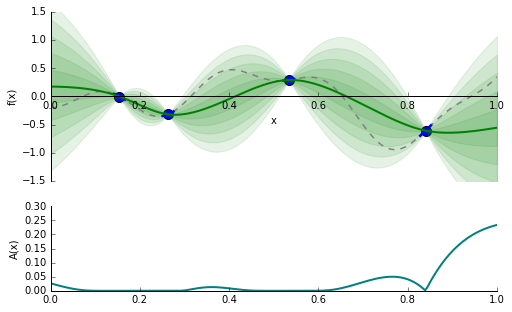

In [4]:
from scipy.stats import norm
import matplotlib.gridspec as gridspec

rv = norm()

x_samp = np.array([0.15416284,0.26331502,0.53373939,.84])

def A(x):
    y_pred, sigma = GP.predict(x.reshape(-1,1), return_std=True)
    gam = (f(x_samp[-1]) - y_pred)/sigma
    phi_gam = rv.cdf(gam)
    return sigma*(gam*phi_gam+rv.pdf(gam))

fig = plt.figure(figsize=(8,5))
# fig, axarr = plt.subplots(2,1,figsize=(8,5))
gs = gridspec.GridSpec(2, 1, width_ratios=[1], height_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0])
ax1 = true_func(ax1)
ax1, GP = guassian_on_four(ax1,x_samp)

def activation_func(ax):
    activation = A(x)
    ax.plot(x,activation,linestyle='-',linewidth=2,color='teal')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('data',0))
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data',0))
    ax.set_ylabel('A(x)')
    ax.set_ylim(0,1)
    
    return ax

ax2 = fig.add_subplot(gs[1])
ax2 = activation_func(ax2)
ax2.set_ylim(0,.3)
fig.savefig('WithActivation.png',dpi=250)

So this would tell us to check at $x=1$ since that point has the highest activation.



### Bayesian Optimization vs Random Sampling

### Extensions

The above example falls short in representing the complexity of this problem. So here are the additional things to keep in mind:

1. Going from input-outputs to inferred functions with a GP requires tuned parameters of the GP itself. There a bit of talent involve in doing this correctly.
2. The above is for a single dimension, but in general, such problem have